In [ ]:
#Importing Libraries

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

In [ ]:
#Getting Images

X = []
for imagename in os.listdir('Dataset/Train/'):
    X.append(img_to_array(load_img('Dataset/Train/'+imagename)))
X = np.array(X, dtype=float)


# Set up train and test data

split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [ ]:
#CNN model

from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential

model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

Epoch 1/500
30/30 [==============================] - 17s 582ms/step - loss: 0.0096 - acc: 0.6252
Epoch 2/500
30/30 [==============================] - 17s 575ms/step - loss: 0.0102 - acc: 0.6143
Epoch 3/500
30/30 [==============================] - 17s 576ms/step - loss: 0.0206 - acc: 0.6107
Epoch 4/500
30/30 [==============================] - 17s 575ms/step - loss: 0.0137 - acc: 0.6236
Epoch 5/500
30/30 [==============================] - 17s 574ms/step - loss: 0.0092 - acc: 0.6125
Epoch 6/500
30/30 [==============================] - 17s 579ms/step - loss: 0.0097 - acc: 0.6140
Epoch 7/500
30/30 [==============================] - 18s 585ms/step - loss: 0.0101 - acc: 0.6065
Epoch 8/500
30/30 [==============================] - 17s 577ms/step - loss: 0.0096 - acc: 0.6292
Epoch 9/500
30/30 [==============================] - 18s 588ms/step - loss: 0.0108 - acc: 0.5941
Epoch 10/500
30/30 [==============================] - 18s 584ms/step - loss: 0.0093 - acc: 0.6231
Epoch 11/500
30/30 [=========

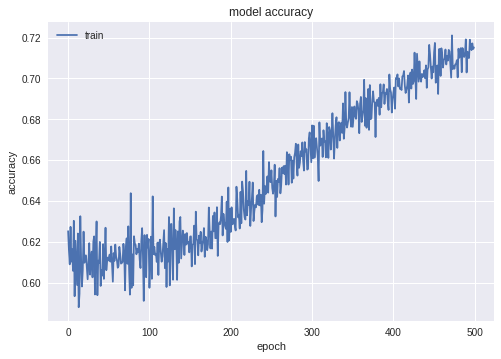

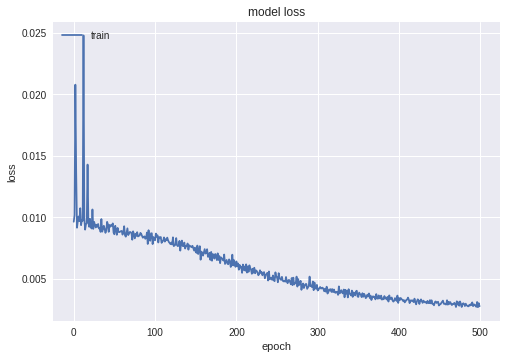

In [ ]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
tensorboard = TensorBoard(log_dir="/output/beta_run")
trainedmodel = model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard],epochs=500, steps_per_epoch=30)


# summarize history for accuracy
plt.plot(trainedmodel.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load json and create model

from keras.models import model_from_json
json_file = open('/content/drive/My Drive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/content/drive/My Drive/model.h5')

In [ ]:
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 512)      

In [ ]:
# Test images

Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(loaded_model.evaluate(Xtest, Ytest, batch_size=32))

In [ ]:
# Manual Testing of Images
import cv2
import os
%matplotlib inline 
from matplotlib import pyplot as plt

fig, ax = plt.subplots(23, 2, figsize=(16,100))
row = 0
colorize = []
print('Output of the Model')
for filename in os.listdir('/content/drive/My Drive/Dataset/Test/'):
	colorize.append(img_to_array(load_img('/content/drive/My Drive/Dataset/Test/'+filename)))
	ax[row,0].imshow(load_img('/content/drive/My Drive/Dataset/Test/'+filename), interpolation='nearest')
	row +=1

colorize = np.array(colorize, dtype=float)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict(colorize)
output = output * 128

row = 0

# Output colorizations
for i in range(len(output)):
	cur = np.zeros((256, 256, 3))
	cur[:,:,0] = colorize[i][:,:,0]
	cur[:,:,1:] = output[i]
	resImage = lab2rgb(cur)
	ax[row,1].imshow(resImage, interpolation='nearest')
	row +=1
    

# 	imsave("result/img_"+str(i)+".png", resImage)
    
    